<h1>Improvements</h1>
<p>Align Shift overlay with side of more forecasted orders</p>
<p>Having rouge shifts at the start and end decreases efficiency</p>


In [1]:
from math import ceil, floor
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import pandas as pd
from tqdm import tqdm

path = "data/dailyOrders.csv"

In [2]:
class Shiftplaner:
    def __init__(self, path):
        self.shifts = []      
        self.dfOrders = pd.read_csv(path)
        self.prepareData()
        
    def getData(self):
        return self.dfOrders
    
    def getShifts(self):
        return self.shifts
    
    
    def findBestCombination(self, width):
        # ----- find best combination of shift types
        bestCombination = {
            'short': 0,
            'long': 0,
            'value': 0
        }
        
        for nShort in range(0, ceil(width / self.durationShortShift) + 1):
            for nLong in range(0, ceil(width / self.durationLongShift) + 1):
                shiftsWidth = nShort * self.durationShortShift + nLong * self.durationLongShift
                if shiftsWidth < width:
                    continue
                
                if bestCombination['value'] == 0 or shiftsWidth < bestCombination['value'] or (shiftsWidth < bestCombination['value'] and bestCombination["long"] < nLong):
                    bestCombination = {
                        'short': nShort,
                        'long': nLong,
                        'value': shiftsWidth
                    }
        if bestCombination['value'] < width: raise Exception("No valid combination found")   
        return bestCombination
    
    
    def plot(self, demand=True, assigned=True, analytics=True):
        dfOrders = self.dfOrders
        shifts = self.shifts
        fig, ax = plt.subplots()
        fig.set_size_inches(20, 10)

        for i, row in dfOrders.iterrows():
            x = row['t']
            y = 0
            width = 1
            height = row['req']
            heightSan = row['san_req']
            if demand: 
                ax.add_patch(Rectangle((x, y), width, height, color='lightblue', alpha=0.5, label='demand' if i == 0 else None))
                ax.add_patch(Rectangle((x, y), width, heightSan, color='blue', alpha=0.5, label='sanitized demand' if i == 0 else None))


        for i, shift in enumerate(shifts):
            x = shift['start']
            y = shift['low']
            width = shift['end'] - shift['start']
            height = shift['high'] - shift['low']
            if assigned: ax.add_patch(Rectangle((x, y), width, height, color='green', alpha=0.5, label='assigned shifts' if i == 0 else None))


        if analytics:
            ax.scatter(dfOrders['t'] + 0.5, dfOrders['dailyHighMarker'] * dfOrders['dailyHigh'], color='red', marker='x', label='high')
            ax.scatter(dfOrders['t'] + 0.5, dfOrders['dailySecondHighMarker'] * dfOrders['dailySecondHigh'], color='red', marker='x')

        ax.vlines(x=dfOrders['t'].where(dfOrders['date'].dt.hour == 0).dropna(), ymin=0, ymax=dfOrders['san_req'].max(), color='black', linestyles='dashed', alpha=0.75, label='midnight')
        ax.hlines(y=0, xmin=dfOrders['t'].min(), xmax=dfOrders['t'].max(), color='black', alpha=0.75)  

        ax.legend()
        plt.xlabel('hour')
        plt.ylabel('# courier')
        plt.show()
    
    def analyze(self):
        dfOrders = self.dfOrders
        
        areaReq = 0
        areaReqSan = 0
        for i, row in dfOrders.iterrows():
            width = 1
            height = row['req']
            areaReq += width * height
            
            heightSan = row['san_req']
            areaReqSan += width * heightSan
        
        areaAssigned = 0
        for shift in self.shifts:
            width = shift['end'] - shift['start'] + 1
            height = shift['high'] - shift['low']
            areaAssigned += width * height
            
        
        return {
            'areaReq': areaReq,
            'areaReqSan': areaReqSan,
            'areaAssigned': areaAssigned,
            'efficiency': areaReq / areaAssigned,
            'efficiencySan': areaReqSan / areaAssigned
        }
    
    def prepareData(self, nOrdersPerCourier=3, durationShortShift=5, durationLongShift=8, windowSize=5, maxOverflowPerc=0, minOverflowInt=0):
        self.nOrdersPerCourier = nOrdersPerCourier
        self.durationShortShift = durationShortShift
        self.durationLongShift = durationLongShift
        
        
        
        dfOrders = self.dfOrders
        dfOrders['date'] = pd.to_datetime(dfOrders['date'], format='%d/%m/%Y %H:%M:%S')
        dfOrders.sort_values(by='date', inplace=True)
        dfOrders['t'] = dfOrders.index

        # ----- add calculated columns
        dfOrders['san_orders'] = dfOrders['nOrders']
        dfOrders['ra'] = dfOrders['nOrders'].rolling(window=windowSize, min_periods=1, center=True).mean()


        # --- distribute load more evenly
        for i, row in dfOrders.iterrows():
            overflow = max(row['san_orders'] - row['ra'], 0)
            allowedOverflow = max(floor(row['san_orders'] * maxOverflowPerc), minOverflowInt)
            dfOrders.loc[i, 'overflow'] = overflow
            dfOrders.loc[i, 'allowedOverflow'] = allowedOverflow
            
            overflow = floor(min(overflow, allowedOverflow))
            dfOrders.loc[i, 'actualOverflow'] = overflow
            dfOrders.loc[i, 'san_orders'] -= overflow
            if i < len(dfOrders) - 1:
                dfOrders.loc[i+1, 'san_orders'] += overflow


        dfOrders['req'] = (dfOrders['nOrders'] / nOrdersPerCourier).apply(ceil)
        dfOrders['san_req'] = (dfOrders['san_orders'] / nOrdersPerCourier).apply(ceil)  
                
        # --- find daily highs
        dfOrders['dailyHigh'] = dfOrders['san_req'].rolling(window=24, min_periods=1, center=True).max()
        dfOrders['dailyHighMarker'] = np.where(dfOrders['san_req'] == dfOrders['dailyHigh'], 1, np.nan)
        nHighs = int(dfOrders['dailyHighMarker'].sum())
        # print(f"Found {nHighs} daily highs")


        # --- find daily second highs
        dfOrders['dailySecondHigh'] = dfOrders['san_req'].rolling(window=6, min_periods=1, center=True).max()
        dfOrders['dailySecondHighMarker'] = np.where((dfOrders['san_req'] == dfOrders['dailySecondHigh']) & (dfOrders['dailyHighMarker'] != 1), 1, np.nan)

        # --- assign each row to a group around daily highs +/- 12 hours
        dfOrders['dailyHighGroup'] = np.nan
        for i, row in dfOrders.iterrows():
            if row['dailyHighMarker'] == 1:
                dfOrders.loc[i-12:i+12, 'dailyHighGroup'] = i
        dfOrders['section'] = dfOrders['dailyHighGroup'].bfill().ffill()
        dfOrders['sectionStart'] = np.where(dfOrders['section'] != dfOrders['section'].shift(1), 1, 0)
    
        
    def createShifts(self, verbosity=0):
        def log(msg, level=1, end="\n"):
            if verbosity >= level:
                print(msg, end=end)
                
        self.shifts = []
        dfWork = self.dfOrders.copy()

        countGroups = 0
        countCombined = 0

        values2process =list(set(dfWork['san_req'].values.tolist()))
        values2process.sort(reverse=True)
        # values2process = values2process[40:]

        for i, value in enumerate(values2process):
            log(f"Processing value {value} ({i+1}/{len(values2process)}): ", 1)
            nextValue = values2process[i+1] if i < len(values2process) - 1 else 0
            
            
            matching = dfWork[dfWork['san_req'] >= value].reset_index()
            matching["group"] = 1
            
            
            # ----- create coherent groups
            for j, row in matching.iterrows():
                # --- check if the hour of j is just one higher than the previous index
                if j > 0 and row["t"] == matching.loc[j-1, "t"] + 1:
                    matching.loc[j, "group"] = matching.loc[j-1, "group"]
                else:
                    matching.loc[j, "group"] = max(matching["group"]) + 1
            
            countGroups += matching["group"].nunique()    
                
            # --- streamline groups that together would fit one long shift instead of two short shifts
            for groupIndex in matching["group"].unique():        
                prevGroupIndex = groupIndex - 1
                log(f"  >>> checking group {groupIndex} and {prevGroupIndex}", 2, end=" ")
                
                dataCurrentGroup = matching[matching["group"] == groupIndex]
                if len(dataCurrentGroup) == 0: continue
                currentStart = min(dataCurrentGroup["t"])
                currentEnd = max(dataCurrentGroup["t"])
                currentWidth = currentEnd - currentStart + 1
                currentBestCombination = self.findBestCombination(currentWidth)
                
                dataPreviousGroup = matching[matching["group"] == prevGroupIndex]
                if len(dataPreviousGroup) == 0: continue
                previousStart = min(dataPreviousGroup["t"])
                previousEnd = max(dataPreviousGroup["t"])
                previousWidth = previousEnd - previousStart + 1
                previousBestCombination = self.findBestCombination(previousWidth)
                
                combinedStart = min(previousStart, currentStart)
                combinedEnd = max(previousEnd, currentEnd)
                combinedWidth = combinedEnd - combinedStart
                combinedBestCombination = self.findBestCombination(combinedWidth)
                log(f"  >>>  current: {currentBestCombination['value']}, previous: {previousBestCombination['value']}, combined: {combinedBestCombination['value']}", 2)
                
                if combinedBestCombination["value"] <= currentBestCombination["value"] + previousBestCombination["value"]:
                    countCombined += 1
                    log(f" >>>  combining", 2)
                    matching.loc[matching["group"] == groupIndex, "group"] = prevGroupIndex
                else:
                    log("", 2)
                
            
            # ----- create shifts  
            nGroups = matching["group"].nunique()   
            for group in matching["group"].unique():
                data = matching[matching["group"] == group]
                start = min(data["t"])
                end = max(data["t"])
                width = end - start + 1
                log(f"   >> group {group}/{nGroups} (w: {width})", 2, end=" ")
                
                
                bestCombination = self.findBestCombination(width)
                log(f"  >>>  split group {group} into {bestCombination['short']} short and {bestCombination['long']} long shifts", 2)
                
                
                # - create shifts
                if bestCombination['value'] == width:
                    start = start
                else:
                    start = ceil(start + width / 2 - bestCombination['value'] / 2)
            
                
                # - assign short shift first => in case of more demand they cans stay longer
                for k in range(bestCombination['short']):
                    self.shifts.append({
                        'start': start,
                        'end': start + self.durationShortShift,
                        'high': value,
                        'low': nextValue + 1
                    })
                    start += self.durationShortShift
                
                # - assign long shift second => in case of less demand they can leave earlier
                for k in range(bestCombination['long']):
                    self.shifts.append({
                        'start': start,
                        'end': start + self.durationLongShift,
                        'high': value,
                        'low': nextValue + 1
                    })
                    start += self.durationLongShift
                
                
            
                
            
            dfWork.loc[matching.t, 'san_req'] = nextValue
            
            # break          
            # if i > 1:
            #     break


        log("\n\n-------------------", 1)
        log(f"Found {countGroups} groups", 1)
        log(f"Combined {countCombined} groups => {countCombined / countGroups * 100:.2f}%", 1)

        log(f"Created {len(self.shifts)} shifts", 1)
    

In [3]:
sp = Shiftplaner(path)
# sp.prepareData(nOrdersPerCourier=3, durationShortShift=3, durationLongShift=7, windowSize=5, maxOverflowPerc=0, minOverflowInt=0)

In [4]:
sp.createShifts(verbosity=2)

Processing value 1387 (1/113): 
  >>> checking group 2 and 1    >> group 2/1 (w: 1)   >>>  split group 2 into 1 short and 0 long shifts
Processing value 1382 (2/113): 
  >>> checking group 2 and 1    >> group 2/1 (w: 2)   >>>  split group 2 into 1 short and 0 long shifts
Processing value 1100 (3/113): 
  >>> checking group 2 and 1    >> group 2/1 (w: 3)   >>>  split group 2 into 1 short and 0 long shifts
Processing value 1018 (4/113): 
  >>> checking group 2 and 1   >>> checking group 3 and 2   >>>  current: 5, previous: 5, combined: 47

   >> group 2/2 (w: 1)   >>>  split group 2 into 1 short and 0 long shifts
   >> group 3/2 (w: 3)   >>>  split group 3 into 1 short and 0 long shifts
Processing value 972 (5/113): 
  >>> checking group 2 and 1   >>> checking group 3 and 2   >>>  current: 5, previous: 5, combined: 47

   >> group 2/2 (w: 2)   >>>  split group 2 into 1 short and 0 long shifts
   >> group 3/2 (w: 3)   >>>  split group 3 into 1 short and 0 long shifts
Processing value 921 

In [5]:
sp.analyze()

{'areaReq': 46427,
 'areaReqSan': 46427,
 'areaAssigned': 60942,
 'efficiency': 0.7618227166814348,
 'efficiencySan': 0.7618227166814348}

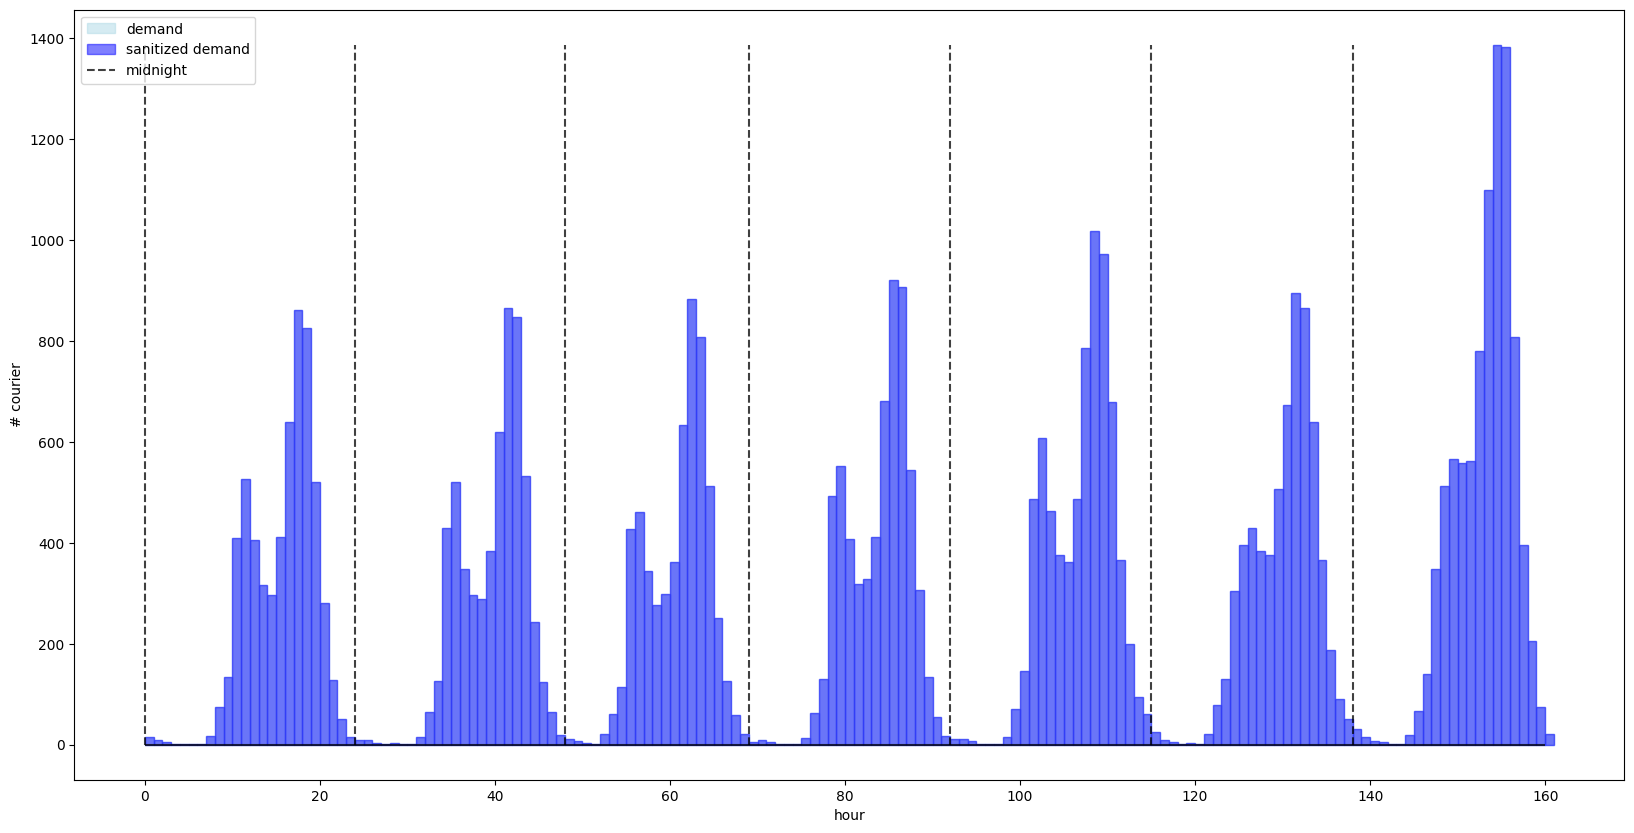

In [8]:
sp.plot(demand=True, assigned=False, analytics=False)

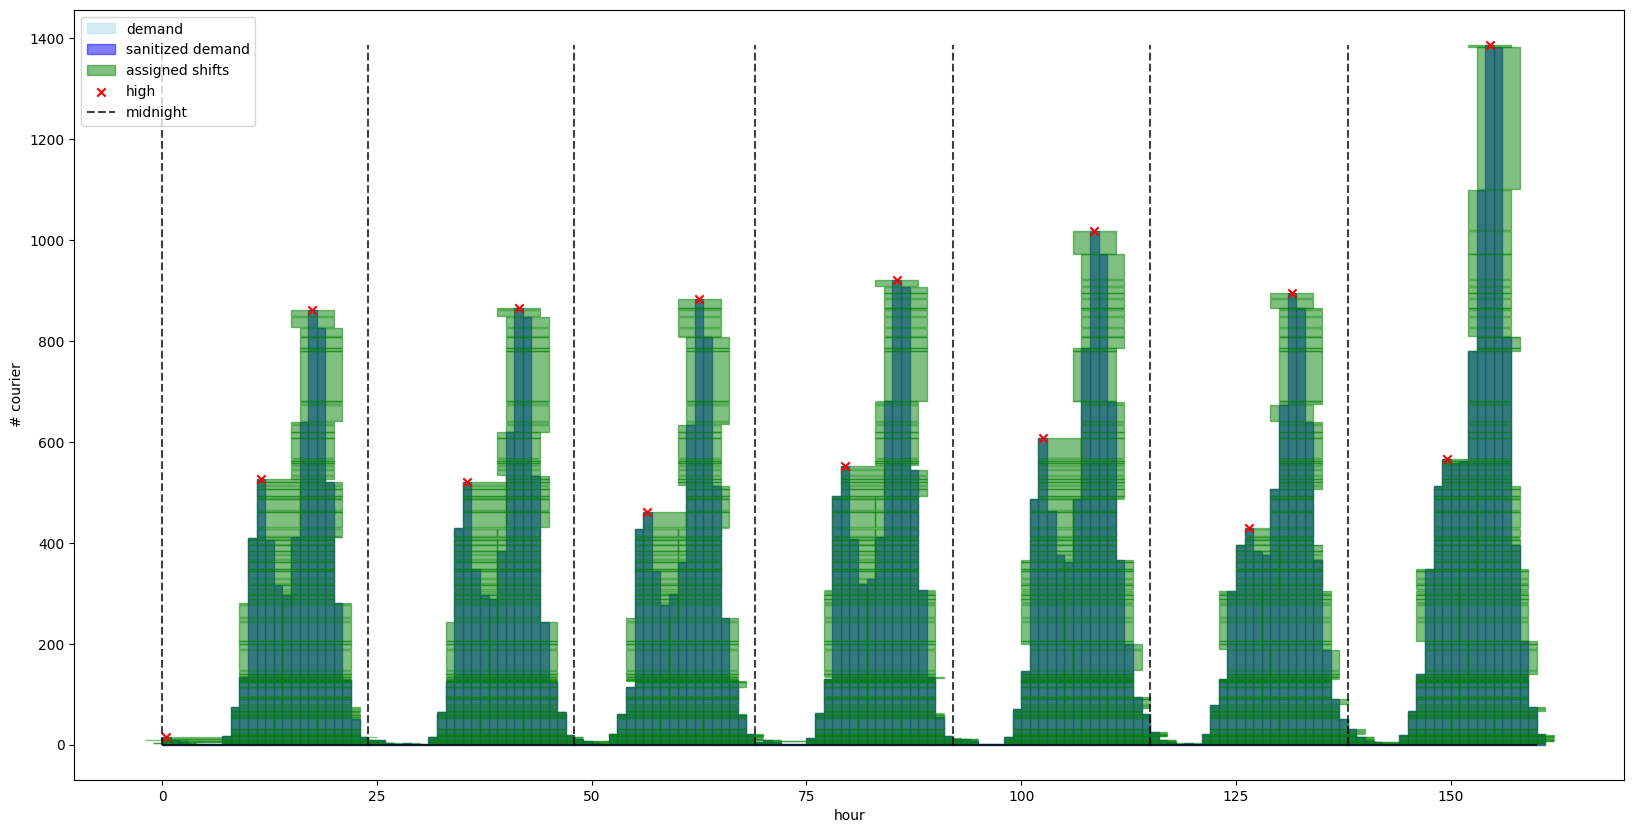

In [6]:
sp.plot()

<h1>Optimizer

In [7]:
spOpt = Shiftplaner(path)

combinations = []
for shortDuration in [3,4,5,6]:
    for longDuration in [7,8,9]:
        for maxOverflowPerc in [0, 0.05, 0.1, 0.15, 0.2]:
            combinations.append({
                'shortDuration': shortDuration,
                'longDuration': longDuration,
                'maxOverflowPerc': maxOverflowPerc
            })
            
            
results = []         
for combination in tqdm(combinations):
    spOpt.prepareData(durationShortShift=combination['shortDuration'], durationLongShift=combination['longDuration'], maxOverflowPerc=combination['maxOverflowPerc'])
    spOpt.createShifts()
    
    results.append({
        **combination,
        **spOpt.analyze()
    })
            
dfResults = pd.DataFrame(results)
dfResults.sort_values(by='efficiency', ascending=False, inplace=True)
dfResults.to_csv("data/results.csv", index=False)
dfResults

100%|██████████| 60/60 [02:25<00:00,  2.43s/it]


,shortDuration,longDuration,maxOverflowPerc,areaReq,areaReqSan,areaAssigned,efficiency,efficiencySan
19,4,7,0.20,46427,46426,56911,0.815783,0.815765
18,4,7,0.15,46427,46423,56914,0.815740,0.815669
5,3,8,0.00,46427,46427,57232,0.811207,0.811207
17,4,7,0.10,46427,46424,57261,0.810796,0.810744
6,3,8,0.05,46427,46427,57304,0.810188,0.810188
16,4,7,0.05,46427,46427,57401,0.808819,0.808819
11,3,9,0.05,46427,46427,57632,0.805577,0.805577
14,3,9,0.20,46427,46426,57698,0.804655,0.804638
10,3,9,0.00,46427,46427,57748,0.803959,0.803959
13,3,9,0.15,46427,46423,57844,0.802624,0.802555


In [10]:
dfResults = pd.read_csv("data/results.csv")

worstCase = dfResults[dfResults['efficiency'] == dfResults['efficiency'].min()].iloc[0]
bestCaseWithOverflow = dfResults[dfResults["maxOverflowPerc"] > 0].iloc[0]
bestCaseWithoutOverflow = dfResults[dfResults["maxOverflowPerc"] == 0].iloc[0]

currentStats = sp.analyze()

print(f"Current case: {currentStats["efficiency"]*100:.2f}% @ short: {sp.durationShortShift}, long: {sp.durationLongShift}, overflow: 0")
print("---")
print(f"Worst case: {worstCase["efficiency"]*100:.2f}% @ short: {worstCase["shortDuration"]}, long: {worstCase["longDuration"]}, overflow: {worstCase["maxOverflowPerc"]}")

print("---")
print(f"Best case (with overflow): {bestCaseWithOverflow["efficiency"]*100:.2f}% @ short: {bestCaseWithOverflow["shortDuration"]}, long: {bestCaseWithOverflow["longDuration"]}, overflow: {bestCaseWithOverflow["maxOverflowPerc"]}")
print(f"Best case (without overflow): {bestCaseWithoutOverflow["efficiency"]*100:.2f}% @ short: {bestCaseWithoutOverflow["shortDuration"]}, long: {bestCaseWithoutOverflow["longDuration"]}, overflow: {bestCaseWithoutOverflow["maxOverflowPerc"]}")



improvementPotentialWithOverflow = (bestCaseWithOverflow["efficiency"] - currentStats["efficiency"]) / currentStats["efficiency"]
improvementPotentialWithoutOverflow = (bestCaseWithoutOverflow["efficiency"] - currentStats["efficiency"]) / currentStats["efficiency"]
print("---")
print(f"Improvement potential (with overflow): {improvementPotentialWithOverflow*100:.2f}%")
print(f"Improvement potential (without overflow): {improvementPotentialWithoutOverflow*100:.2f}%")


Current case: 76.18% @ short: 5, long: 8, overflow: 0
---
Worst case: 69.90% @ short: 6.0, long: 7.0, overflow: 0.0
---
Best case (with overflow): 81.58% @ short: 4.0, long: 7.0, overflow: 0.2
Best case (without overflow): 81.12% @ short: 3.0, long: 8.0, overflow: 0.0
---
Improvement potential (with overflow): 7.08%
Improvement potential (without overflow): 6.48%
